In [31]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

In [3]:
train_data = datasets.MNIST(
    root='data',
    train = True,
    transform = ToTensor(),
    download = True
)

test_data = datasets.MNIST(
    root='data',
    train = False,
    transform = ToTensor(),
    download = True
)

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.22MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 245kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


In [ ]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [27]:
loaders = {
    "train" : DataLoader(train_data,
                        batch_size=102,
                        shuffle=True,
                        num_workers=1),

    "test" : DataLoader(test_data,
                        batch_size=102,
                        shuffle=True,
                        num_workers=1)
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x19cb8819490>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x19cbe2c7470>}

In [33]:
class CNN(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1,10, kernel_size=5)
        self.conv2 = nn.Conv2d(10,20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50,10)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x),2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)    
        x = self.fc2(x)

        return F.softmax(x)


In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.001)
loss_fc = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fc(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx*len(data)}/{len(loaders['train'].dataset)} ({100. * batch_idx / len(loaders['train']):.0f}%)]\t{loss.item():.6f}")

def test():
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fc(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(loaders['test'].dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders['test'].dataset)} ({100. * correct/len(loaders['test'].dataset):.0f})%")

In [36]:
for epoch in range(1,11):
    train(epoch)
    test()

C:\Users\Home\AppData\Local\Temp\ipykernel_11268\102621789.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train Epoch: 1 [0/60000 (0%)]	2.303082
Train Epoch: 1 [2040/60000 (3%)]	2.287991
Train Epoch: 1 [4080/60000 (7%)]	2.144021
Train Epoch: 1 [6120/60000 (10%)]	2.040195
Train Epoch: 1 [8160/60000 (14%)]	1.928551
Train Epoch: 1 [10200/60000 (17%)]	1.791826
Train Epoch: 1 [12240/60000 (20%)]	1.801930
Train Epoch: 1 [14280/60000 (24%)]	1.745173
Train Epoch: 1 [16320/60000 (27%)]	1.764813
Train Epoch: 1 [18360/60000 (31%)]	1.749981
Train Epoch: 1 [20400/60000 (34%)]	1.725268
Train Epoch: 1 [22440/60000 (37%)]	1.643504
Train Epoch: 1 [24480/60000 (41%)]	1.699190
Train Epoch: 1 [26520/60000 (44%)]	1.727812
Train Epoch: 1 [28560/60000 (48%)]	1.703591
Train Epoch: 1 [30600/60000 (51%)]	1.634547
Train Epoch: 1 [32640/60000 (54%)]	1.672185
Train Epoch: 1 [34680/60000 (58%)]	1.652503
Train Epoch: 1 [36720/60000 (61%)]	1.607160
Train Epoch: 1 [38760/60000 (65%)]	1.629075
Train Epoch: 1 [40800/60000 (68%)]	1.637678
Train Epoch: 1 [42840/60000 (71%)]	1.614364
Train Epoch: 1 [44880/60000 (75%)]	1.632585

In [37]:
device

device(type='cuda')

C:\Users\Home\AppData\Local\Temp\ipykernel_11268\102621789.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Prediction:  4


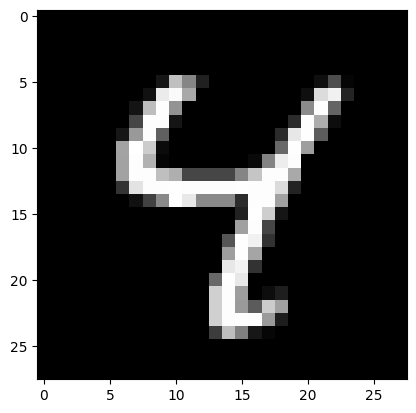

In [41]:
model.eval()

data, target = test_data[6]

data = data.unsqueeze(0).to(device)
output = model(data)

pred = output.argmax(dim = 1, keepdim = True).item()

print(f"Prediction: ", pred)

image = data.squeeze(0).squeeze(0).cpu().numpy()
plt.imshow(image,cmap='gray')
plt.show()